In [ ]:
import numpy as np
import pandas as pd
import os
import time
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from glob import glob
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


import PIL
import cv2
import pickle

In [ ]:
import cv2
import glob

address = "/content/drive/MyDrive/Car_detection_UAV_SIFT/data_org_UAV/"

images = []
labels = []

for each_dir in glob.glob(address + "*/"):
    for each_pic in glob.glob(each_dir + "*"):
        img = cv2.imread(each_pic)
        # img = cv2.resize(img, (256,256))

        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        images.append(img)

        label = each_dir.split("/")[-2]
        labels.append(label)

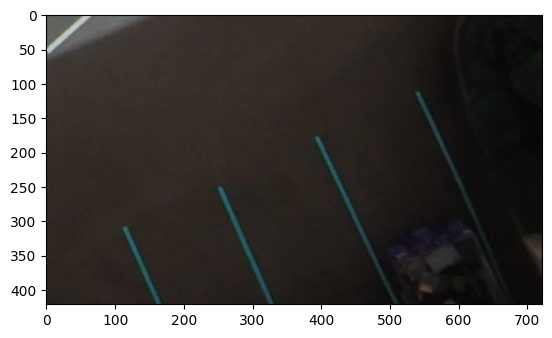

In [ ]:
plt.imshow(images[64], cmap='gray')

In [ ]:
import numpy as np

# generate an array from the original dataset
images_training = []

for n in range(0,len(images)):
    images_training.append(np.array(images[n]))

In [ ]:
import cv2

# convert images to grayscale
bw_images = []
for img in images_training:
    # if RGB, transform into grayscale
    if len(img.shape) == 3:
        bw_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    else:
        # if grayscale, do not transform
        bw_images.append(img)

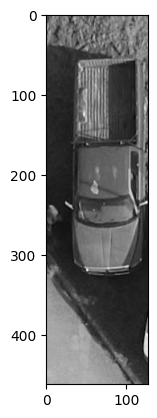

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(bw_images[1], cmap='gray')
plt.show()

In [ ]:
# defining feature extractor that we want to use (SIFT)
extractor = cv2.xfeatures2d.SIFT_create()

# initialize lists where we will store *all* keypoints and descriptors
keypoints = []
descriptors = []

for img in bw_images:
    # extract keypoints and descriptors for each image
    img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
    keypoints.append(img_keypoints)
    descriptors.append(img_descriptors)

In [ ]:
print(f"len before: {len(descriptors)}")
# initialize list to store idx values of records to drop
to_drop = []
for i, img_descriptors in enumerate(descriptors):
    # if there are no descriptors, add record idx to drop list
    if img_descriptors is None:
        to_drop.append(i)

print(f"indexes: {to_drop}")
# delete from list in reverse order
for i in sorted(to_drop, reverse=True):
    del descriptors[i], keypoints[i]

print(f"len after: {len(descriptors)}")

len before: 109
indexes: []
len after: 109


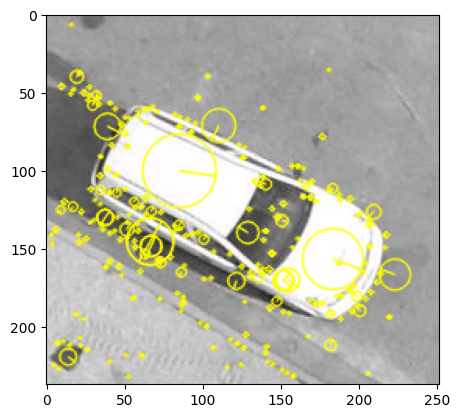

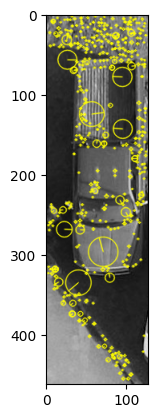

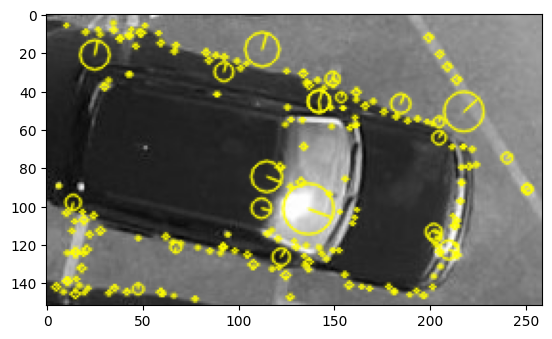

In [ ]:
output_image = []
for x in range(3):
    output_image.append(cv2.drawKeypoints(bw_images[x], keypoints[x], 0, (255, 255, 0),
                                 flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
    plt.imshow(output_image[x], cmap='gray')
    plt.show()


In [ ]:
import numpy as np

# select the same numbers in each run
np.random.seed(0)
# select 80 random image index values
sample_idx = np.random.randint(0, len(images)+1, 80).tolist()
print(len(sample_idx))

80


In [ ]:
print(sample_idx)

[44, 47, 64, 67, 67, 103, 9, 83, 21, 36, 87, 70, 88, 88, 12, 58, 65, 102, 39, 87, 46, 88, 81, 37, 25, 77, 72, 9, 20, 80, 69, 79, 47, 64, 82, 99, 88, 49, 29, 19, 19, 14, 39, 32, 65, 9, 57, 32, 31, 74, 23, 35, 75, 55, 28, 34, 0, 0, 36, 53, 5, 38, 104, 17, 79, 4, 105, 42, 58, 31, 1, 65, 103, 41, 57, 35, 102, 11, 46, 82]


In [ ]:
# extract the sample from descriptors
# (we don't need keypoints)
descriptors_sample = []

for n in sample_idx:
    descriptors_sample.append(np.array(descriptors[n-1]))

In [ ]:
all_descriptors = []
# extract image descriptor lists
for img_descriptors in descriptors_sample:
    # extract specific descriptors within the image
    for descriptor in img_descriptors:
        all_descriptors.append(descriptor)
# convert to single numpy array
all_descriptors = np.stack(all_descriptors)

In [ ]:
# check the shape
all_descriptors.shape

(202646, 128)

In [ ]:
# we can count the number of descriptors contained in descriptors to confirm
count = []
for img_descriptors in descriptors_sample:
    count.append(len(img_descriptors))
# here we can see the number of descriptors for the first five images
print(f"first five: {count[:5]}")
# and if we sum them all, we should see the 322202 from before
print(f"count all: {sum(count)}")

first five: [77219, 785, 594, 1227, 1227]
count all: 202646


In [ ]:
# perform k-means clustering to build the codebook
from scipy.cluster.vq import kmeans

k = 150
iters = 1
codebook, variance = kmeans(all_descriptors, k, iters)

In [ ]:
import joblib

# save number of clusters and codebook
# Joblib dumps Python object into one file
joblib.dump((k, codebook), "bovw-codebook.pkl", compress=3)

['bovw-codebook.pkl']

In [ ]:
# load the visual features, number of clusters, and codebook
k, codebook = joblib.load("bovw-codebook.pkl")

In [ ]:
# vector quantization
from scipy.cluster.vq import vq

visual_words = []
for img_descriptors in descriptors:
    # for each image, map each descriptor to the nearest codebook entry
    img_visual_words, distance = vq(img_descriptors, codebook)
    visual_words.append(img_visual_words)

In [ ]:
# let's see what the visual words look like for image 0
visual_words[0][:5], len(visual_words[0])

(array([ 95, 139,  29, 124,  76], dtype=int32), 278)

In [ ]:
# the centroid that represents visual word 84 is of dimensionality...
codebook[14].shape  # (all have the same dimensionality)

(128,)

In [ ]:
len(visual_words)

109

In [ ]:
frequency_vectors = []
for img_visual_words in visual_words:
    # create a frequency vector for each image
    img_frequency_vector = np.zeros(k)
    for word in img_visual_words:
        img_frequency_vector[word] += 1
    frequency_vectors.append(img_frequency_vector)
# stack together in numpy array
frequency_vectors = np.stack(frequency_vectors)

In [ ]:
frequency_vectors.shape

(109, 150)

In [ ]:
# we know from above that ids 95, 139, 29, 124, 76 appear in image 0
for i in [95, 139, 29, 124, 76]:
    print(f"{i}: {frequency_vectors[0][i]}")

95: 1.0
139: 4.0
29: 2.0
124: 3.0
76: 3.0


In [ ]:
frequency_vectors[0][:20]

array([ 2.,  0.,  0.,  0., 13.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,
        0.,  0.,  1.,  4., 11.,  0.,  5.])

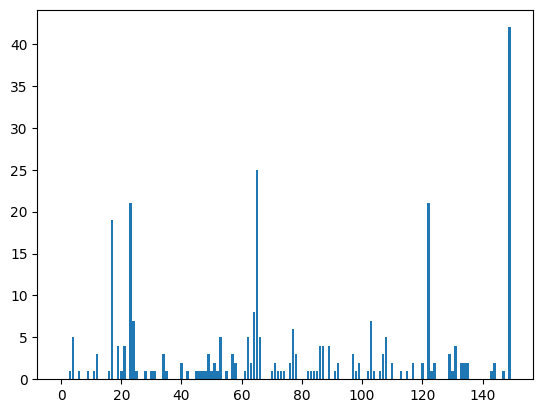

In [ ]:
plt.bar(list(range(k)), frequency_vectors[10])
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
labels = np.array(labels)
f = np.array(frequency_vectors)
x_train, x_test, y_train, y_test = train_test_split(f, labels, train_size=0.8)

In [ ]:
from sklearn import svm

model = svm.SVC(kernel='rbf')
model.fit(x_train, y_train)

print(model.score(x_test, y_test))

y_pred = model.predict(x_test)
print("Accuracy score of model is ",round(accuracy_score(y_pred=y_pred,y_true=y_test)*100, 2))

0.7272727272727273
Accuracy score of model is  72.73


In [ ]:
# Make predictions on the test set
y_pred = model.predict(x_test)

# Calculate accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate U and P measure
TP = cm[1, 1]
FP = cm[0, 1]
FN = cm[1, 0]

U = 2 * TP / (2 * TP + FP + FN)
P = TP / (TP + FP)
A = (U + P)/2

print("U measure: {:.2f}%".format(U * 100))
print("P measure: {:.2f}%".format(P * 100))
print("A measure: {:.2f}%".format(A * 100))

Accuracy: 72.73%
U measure: 84.21%
P measure: 72.73%
A measure: 78.47%


##Test on image

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


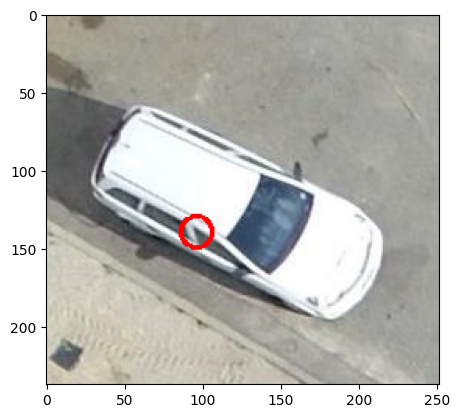

Object coordinates:
Object 1: (96.9559326171875, 139.37484741210938)


In [ ]:
# load the test image
test_image = cv2.imread("/content/0.jpg")

# convert the test image to grayscale
test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

# extract keypoints and descriptors for the test image
test_keypoints, test_descriptors = extractor.detectAndCompute(test_image_gray, None)

# map the test descriptors to the nearest codebook entry
test_visual_words, distance = vq(test_descriptors, codebook)

# Perform clustering on the keypoints
from sklearn.cluster import KMeans
num_clusters = 1  # You can adjust this parameter to change the number of clusters

keypoint_coords = []
for kp in test_keypoints:
    keypoint_coords.append([kp.pt[0], kp.pt[1]])
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(keypoint_coords)

centers = kmeans.cluster_centers_

# Create a list to store the coordinates of each object
object_coordinates = []

# Calculate the coordinates of each object based on the nearest cluster center
for center in centers:
    x_center = int(center[0])
    y_center = int(center[1])
    min_distance = float('inf')
    object_coordinate = None
    for i, keypoint in enumerate(test_keypoints):
        distance = np.sqrt((keypoint.pt[0] - x_center) ** 2 + (keypoint.pt[1] - y_center) ** 2)
        if distance < min_distance:
            min_distance = distance
            object_coordinate = keypoint.pt
    object_coordinates.append(object_coordinate)

# Draw a red circle at the center of each object
for coordinate in object_coordinates:
    x_center = int(coordinate[0])
    y_center = int(coordinate[1])
    radius = 10
    thickness = 2
    color = (0, 0, 255)
    image_with_center = cv2.circle(test_image, (x_center, y_center), radius, color, thickness)

# Show the image with the centers of the objects
plt.imshow(cv2.cvtColor(image_with_center, cv2.COLOR_BGR2RGB))
plt.show()

# Print the coordinates of each object
print("Object coordinates:")
for i, coordinate in enumerate(object_coordinates):
    print("Object {}: ({}, {})".format(i+1, coordinate[0], coordinate[1]))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


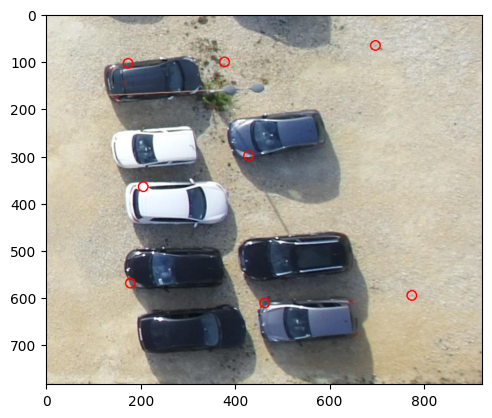

Object coordinates:
Object 1: (377.9347229003906, 101.32597351074219)
Object 2: (773.82666015625, 595.4376220703125)
Object 3: (205.20794677734375, 365.2516784667969)
Object 4: (462.91058349609375, 611.844482421875)
Object 5: (178.95755004882812, 569.9982299804688)
Object 6: (696.78271484375, 66.6143798828125)
Object 7: (173.229248046875, 104.45861053466797)
Object 8: (428.0781555175781, 299.932861328125)


In [ ]:
# load the test image
test_image = cv2.imread("/content/test.jpg")

# convert the test image to grayscale
test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

# extract keypoints and descriptors for the test image
test_keypoints, test_descriptors = extractor.detectAndCompute(test_image_gray, None)

# map the test descriptors to the nearest codebook entry
test_visual_words, distance = vq(test_descriptors, codebook)

# Perform clustering on the keypoints
from sklearn.cluster import KMeans
num_clusters = 8  # You can adjust this parameter to change the number of clusters

keypoint_coords = []
for kp in test_keypoints:
    keypoint_coords.append([kp.pt[0], kp.pt[1]])
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(keypoint_coords)

centers = kmeans.cluster_centers_

# Create a list to store the coordinates of each object
object_coordinates = []

# Calculate the coordinates of each object based on the nearest cluster center
for center in centers:
    x_center = int(center[0])
    y_center = int(center[1])
    min_distance = float('inf')
    object_coordinate = None
    for i, keypoint in enumerate(test_keypoints):
        distance = np.sqrt((keypoint.pt[0] - x_center) ** 2 + (keypoint.pt[1] - y_center) ** 2)
        if distance < min_distance:
            min_distance = distance
            object_coordinate = keypoint.pt
    object_coordinates.append(object_coordinate)

# Draw a red circle at the center of each object
for coordinate in object_coordinates:
    x_center = int(coordinate[0])
    y_center = int(coordinate[1])
    radius = 10
    thickness = 2
    color = (0, 0, 255)
    image_with_center = cv2.circle(test_image, (x_center, y_center), radius, color, thickness)

# Show the image with the centers of the objects
plt.imshow(cv2.cvtColor(image_with_center, cv2.COLOR_BGR2RGB))
plt.show()

# Print the coordinates of each object
print("Object coordinates:")
for i, coordinate in enumerate(object_coordinates):
    print("Object {}: ({}, {})".format(i+1, coordinate[0], coordinate[1]))

##test


Predicted label: no car


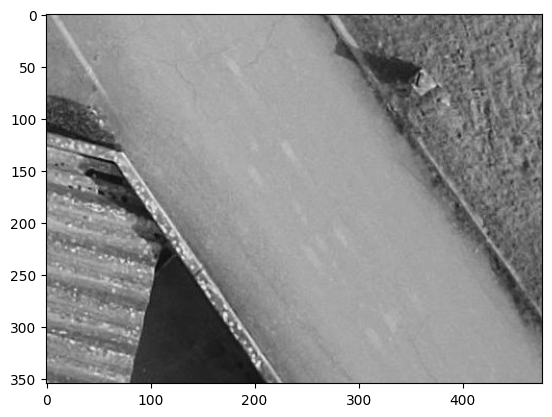

In [ ]:
# Load the test image
test_image = cv2.imread("/content/1_00.jpg")

# Convert the test image to grayscale
test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

# Extract keypoints and descriptors for the test image
test_keypoints, test_descriptors = extractor.detectAndCompute(test_image_gray, None)

# Map the test descriptors to the nearest codebook entry
test_visual_words, distance = vq(test_descriptors, codebook)

# Create a frequency vector for the test image
test_frequency_vector = np.zeros(k)
for word in test_visual_words:
    test_frequency_vector[word] += 1

# Use the trained SVM model to predict the label of the test image
predicted_label = model.predict([test_frequency_vector])[0]

# Print the predicted label
print("Predicted label:", predicted_label)
plt.imshow(test_image_gray, cmap='gray')